### Import module

In [1]:
from glob import glob
import os, sys
from os.path import join, dirname

import datetime, time
import csv
from glob import glob
import chardet
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler, MinMaxScaler

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, SimpleRNN, LSTM, GRU, Reshape, RepeatVector, MaxPooling2D, Dropout, Bidirectional, Attention, BatchNormalization, Conv2DTranspose, TimeDistributed
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot

import imblearn

from IPython.display import SVG

import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
device_lib.list_local_devices()

2.3.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3136607562160073353,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8377363359132279434
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3129973147
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11185231795476836962
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 467105377208401200
 physical_device_desc: "device: XLA_GPU device"]

### Global Parameter

In [2]:
num_classes = 7                           # {"0" : "Playing", "1" : "Talking", "2" : "Petting", "3" : "TV / Radio", "4" : "Eating / Cooking", "5" : "Moved It", "6" : "None of the above", "7" : "Other"}
time_offset = 10
window_size = 50
overlap_ratio = 0.5
bi_class = 0                              # Binary Classification (1 : Playing or not, 2 : Talking or not, 3 : Petting or not, 4: TV / Radio or not, 5 : Eating / Cooking or not, 6 : Moved It or not)
cross_val = 0
rand_st=2
mode = 0                                 # Split data {0: Didn't split, 1: US only, 2: Korea only, 3: train with US and test with Korea 4: train with Korea and test with US}

### Load Data

In [3]:
data_fname = '../Data/Preprocessed(new)/preprocessed_data(New collar_2).csv'

### Preprocess Data

In [4]:
data = pd.read_csv(data_fname)
data = data.fillna(0)

In [5]:
iaq = data['iaq']
iaq_cat = []

for num in iaq:
    if num < 50 and num >=0:
        iaq_cat.append('Good')
    elif num >= 50 and num < 100:
        iaq_cat.append('Average')
    elif num >= 100 and num < 150:
        iaq_cat.append('Little bad')
    elif num >= 150 and num < 200:
        iaq_cat.append('Bad')
    elif num >= 200 and num < 300:
        iaq_cat.append('Worse')
    elif num >= 300 and num <= 500:
        iaq_cat.append('Very bad')
    else:
        print(num)
data['iaq_cat'] = iaq_cat

In [6]:
data = pd.concat([data,pd.get_dummies(data['sound category'])],axis=1)         # Onehot encode sound category
data = pd.concat([data,pd.get_dummies(data['orientation_cat'])],axis=1)         # Onehot encode orientation category
data = pd.concat([data,pd.get_dummies(data['iaq_cat'])],axis=1)         # Onehot encode iaq category

In [7]:
# Create rowID list
rowID_list = np.array(data['RowID'].drop_duplicates())
data = data.to_records(index=False)

In [8]:
# Normalize Data

scaler = StandardScaler()

# data['pressure'] = scaler.fit_transform(data['pressure'].reshape(-1,1)).reshape(-1)
data['gasResistance'] = scaler.fit_transform(data['gasResistance'].reshape(-1,1)).reshape(-1)
data['staticIaq'] = scaler.fit_transform(data['staticIaq'].reshape(-1,1)).reshape(-1)
data['co2Equivalent'] = scaler.fit_transform(data['co2Equivalent'].reshape(-1,1)).reshape(-1)
data['breathVocEquivalent'] = scaler.fit_transform(data['breathVocEquivalent'].reshape(-1,1)).reshape(-1)
data['audioLevel'] = scaler.fit_transform(data['audioLevel'].reshape(-1,1)).reshape(-1)
data['rawTemp'] = scaler.fit_transform(data['rawTemp'].reshape(-1,1)).reshape(-1)
data['rawHumidity'] = scaler.fit_transform(data['rawHumidity'].reshape(-1,1)).reshape(-1)
data['pressure'] = scaler.fit_transform(data['pressure'].reshape(-1,1)).reshape(-1)

In [9]:
# Split US and Korea
us_rowIDs = []
korea_rowIDs = []

if mode != 0:
    for rowid in rowID_list:
    #     print(rowid, rowid[0])
        if rowid[0] == '1':
            korea_rowIDs.append(rowid)
        else:
            us_rowIDs.append(rowid)

In [10]:
# feature_col_name = ['accX', 'accY', 'accZ', 'chord', 'orientation', 'ir', 'full', 'iaq', 'iaqAccuracy', 'rawTemp',
#                     'pressure', 'rawHumidity', 'gasResistance', 'compGasAccuracy', 'gasPercentageAccuracy', 'temperature', 
#                     'humidity', 'staticIaq', 'statIaqAccuracy', 'co2Equivalent', 'co2Accuracy', 'breathVocEquivalent', 
#                     'breathVocAccuracy', 'audioLevel', 'Loud', 'Moderate', 'Quiet']
feature_col_name = ['accX', 'accY', 'accZ', 'chord', 'full', 'iaq', 'rawTemp',
                    'pressure', 'rawHumidity', 'gasResistance', 'staticIaq', 'co2Equivalent', 'breathVocEquivalent', 
                    'audioLevel', 'Loud', 'Moderate', 'Quiet', 'Landscape Left Back', 'Landscape Left Front', 'Landscape Right Back',
                    'Landscape Right Front', 'Portrait Down Back', 'Portrait Down Front', 'Portrait Up Back', 
                    'Portrait Up Front', 'Average', 'Bad', 'Good', 'Little bad', 'Very bad', 'Worse']
target_col_name = ['Modality_cat']

In [11]:
feature_num = len(feature_col_name)

In [12]:
X = []
us_X = []
korea_X = []

Y = []
us_Y = []
korea_Y = []


if mode != 0:
    for rowID in us_rowIDs:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        us_X.append(feature)
        us_Y.append(target)
    
    for rowID in korea_rowIDs:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        korea_X.append(feature)
        korea_Y.append(target)

else:
    for rowID in rowID_list:
        #Split raw data by rowID & split X, Y data
        tmp_data = data[data['RowID'] == rowID]
        feature = tmp_data[feature_col_name]
        feature = np.array(feature.tolist())
        target = tmp_data[target_col_name][0][0]
        target = np.array(target.tolist())
        X.append(feature)
        Y.append(target)

In [13]:
if bi_class != 0:
    #Transit multi classification to binary classification
    if mode != 0:
        for idx in range(len(us_Y)):
            if us_Y[idx] == bi_class-1:
                us_Y[idx]=1
            else:
                us_Y[idx]=0
                
        for idx in range(len(korea_Y)):
            if korea_Y[idx] == bi_class-1:
                korea_Y[idx]=1
            else:
                korea_Y[idx]=0
    else:
        for idx in range(len(Y)):
            if Y[idx] == bi_class-1:
                Y[idx]=1
            else:
                Y[idx]=0

In [14]:
def X_preprocess(X, window_size, overlap_ratio):
    #Transform data shape using the set time window
    processed_X = []
    
    for i in range(len(X)):
        tmp_X = X[i]
        tmp = []
        start_row = 0
        end_row = start_row + window_size
        
        if len(tmp_X)%int(window_size*overlap_ratio) == 0:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)-1):
                tmp.append(tmp_X[int(start_row):int(end_row)])
                start_row += (window_size*overlap_ratio)
                end_row += (window_size*overlap_ratio)
        else:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)+1):
                if end_row > len(tmp_X):
                    
                    tmp.append(tmp_X[-window_size:])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
                    break
                else:
                    
                    tmp.append(tmp_X[int(start_row):int(end_row)])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
        processed_X.append(tmp)
        
    return processed_X

In [15]:
if mode != 0:
    us_X = X_preprocess(us_X, window_size, overlap_ratio)        ### preprocess with input shape
    korea_X = X_preprocess(korea_X, window_size, overlap_ratio)
    if bi_class == 0:
        ### onehot encode Y
        us_Y = np.eye(num_classes)[us_Y]
        korea_Y = np.eye(num_classes)[korea_Y]
    else: 
        us_Y = np.eye(2)[us_Y]
        korea_Y = np.eye(2)[korea_Y]

else:    
    X = X_preprocess(X, window_size, overlap_ratio)        ### preprocess with input shape
    if bi_class == 0:
        ### onehot encode Y
        Y = np.eye(num_classes)[Y]
    else: Y = np.eye(2)[Y]

In [16]:
# Subsample X Data size

def subsample(X, min_us_len, min_korea_len):
    sampled_X = []
    addon = 0
    
    if min_korea_len > min_us_len:
        if np.array(X).shape[1] == min_us_len:
            return X
        else:
            interval = min_korea_len / min_us_len
            quotient = int(np.modf(interval)[1])
            remainder = np.modf(interval)[0]

            for i in range(len(X)):
                temp_X = []
                for j in range(min_us_len):
                    if addon >= 1:
                        temp_X.append(X[i][j*quotient + 1])
                        addon = 0
                        addon += remainder
                    else:
                        temp_X.append(X[i][j*quotient])
                        addon += remainder

                sampled_X.append(temp_X)
            
    else:
        if np.array(X).shape[1] == min_korea_len:
            return X
        else:
            interval = min_us_len / min_korea_len
            quotient = int(np.modf(interval)[1])
            remainder = np.modf(interval)[0]

            for i in range(len(X)):
                temp_X = []
                for j in range(min_korea_len):
                    if addon >= 1:
                        temp_X.append(X[i][j*quotient + 1])
                        addon = 0
                        addon += remainder
                    else:
                        temp_X.append(X[i][j*quotient])
                        addon += remainder

            sampled_X.append(temp_X)
                    
    return sampled_X

In [17]:
# Fit to minimum length

min_len = 99999999
min_us_len = 99999999
min_korea_len = 99999999
min_X = []
min_us_X = []
min_korea_X = []

if mode == 0:
#     print('Start mode 0\n')
    for x in X:
        if len(x) < min_len:
            min_len = len(x)
#     print(min_len)

    for x in X:
        min_X.append(x[:min_len])

else:
    for x in us_X:
        if len(x) < min_us_len:
            min_us_len = len(x)
            
    for x in korea_X:
        if len(x) < min_korea_len:
            min_korea_len = len(x)
            
    if mode == 1:
        for x in us_X:
            min_us_X.append(x[:min_us_len])
        for x in korea_X:
            min_korea_X.append(x[:min_korea_len])
        
    elif mode == 2:
        min_korea_len = 60
        for x in us_X:
            min_us_X.append(x[:min_us_len])
        for x in korea_X:
            min_korea_X.append(x[:min_korea_len])
        
    else:
        if min_korea_len < min_us_len:
            min_len = min_korea_len
        else: min_len = min_us_len

        for x in us_X:
            min_us_X.append(x[:min_len])

        for x in korea_X:
            min_korea_X.append(x[:min_len])

In [18]:
# Drop duplicate

if bi_class != 0:
    
    target_list = []
    us_target_list = []
    korea_target_list = []
    del_list = []
    us_del_list = []
    korea_del_list = []
    
    if mode == 0:
        for i in range(len(Y)):
            if Y[i][1] == 1:
                target_list.append(i)

        for i in target_list:
            for j in range(len(min_X)):
                if j in target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_X[i]), np.array(min_X[j])):
                        if j not in del_list:
                            del_list.append(j)
        X = []
        Target = []

        for i in range(len(Y)):
            if i not in del_list:
                X.append(min_X[i])
                Target.append(Y[i])
                
    else:
        for i in range(len(us_Y)):
            if us_Y[i][1] == 1:
                us_target_list.append(i)

        for i in us_target_list:
            for j in range(len(min_us_X)):
                if j in us_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_us_X[i]), np.array(min_us_X[j])):
                        if j not in us_del_list:
                            us_del_list.append(j)
                            
        for i in range(len(korea_Y)):
            if korea_Y[i][1] == 1:
                korea_target_list.append(i)

        for i in korea_target_list:
            for j in range(len(min_korea_X)):
                if j in korea_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_korea_X[i]), np.array(min_korea_X[j])):
                        if j not in korea_del_list:
                            korea_del_list.append(j)
        
        us_X = []
        us_Target = []
        korea_X = []
        korea_Target = []

        for i in range(len(us_Y)):
            if i not in us_del_list:
                us_X.append(min_us_X[i])
                us_Target.append(us_Y[i])
                
        for i in range(len(korea_Y)):
            if i not in korea_del_list:
                korea_X.append(min_korea_X[i])
                korea_Target.append(korea_Y[i])

else:
    target_list = []
    us_target_list = []
    korea_target_list = []
    del_list = []
    us_del_list = []
    korea_del_list = []
    
    if mode == 0:
        X = min_X
        Target = Y

    else:
        for i in range(len(us_Y)):
            if us_Y[i][1] == 1:
                us_target_list.append(i)

        for i in us_target_list:
            for j in range(len(min_us_X)):
                if j in us_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_us_X[i]), np.array(min_us_X[j])):
                        if j not in us_del_list:
                            us_del_list.append(j)

        for i in range(len(korea_Y)):
            if korea_Y[i][1] == 1:
                korea_target_list.append(i)

        for i in korea_target_list:
            for j in range(len(min_korea_X)):
                if j in korea_target_list:
                    pass
                else:
                    if np.array_equal(np.array(min_korea_X[i]), np.array(min_korea_X[j])):
                        if j not in korea_del_list:
                            korea_del_list.append(j)

        us_X = []
        us_Target = []
        korea_X = []
        korea_Target = []

        for i in range(len(us_Y)):
            if i not in us_del_list:
                us_X.append(min_us_X[i])
                us_Target.append(us_Y[i])

        for i in range(len(korea_Y)):
            if i not in korea_del_list:
                korea_X.append(min_korea_X[i])
                korea_Target.append(korea_Y[i])

In [19]:
if mode == 0:
#     X = subsample(X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Target, test_size=0.2)
    
elif mode == 1:
    us_X = subsample(us_X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(us_X, us_Target, test_size=0.2)

elif mode == 2:
    korea_X = subsample(korea_X, min_us_len, min_korea_len)
    X_train, X_test, Y_train, Y_test = train_test_split(korea_X, korea_Target, test_size=0.2)

elif mode == 3:
    X_train = subsample(us_X, min_us_len, min_korea_len)
    X_test = subsample(korea_X, min_us_len, min_korea_len)
    Y_train = us_Target 
    Y_test = korea_Target

else:
    X_train = subsample(korea_X, min_us_len, min_korea_len)
    X_test = subsample(us_X, min_us_len, min_korea_len)
    Y_train = korea_Target
    Y_test = us_Target 

-----------------------------------------
### End Setup, separate model sections
-----------------------------------------

### Generative Replay #3 - Variational Autoencoder
- https://blog.keras.io/building-autoencoders-in-keras.html (scroll down to VAE section near end)
- https://keras.io/examples/generative/vae/
- https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/
- https://github.com/analytique-bourassa/VAE-Classifier

In [20]:
### Data Setup ###

#Rebalance the data
if bi_class == 0:
    sm = imblearn.over_sampling.SMOTE()
    X_shape = np.array(X_train).shape
    Y_shape = np.array(Y_train).shape
    new_X_train = np.array(X_train).reshape(X_shape[0], X_shape[1]*X_shape[2]*X_shape[3])
    Y_train = np.array(Y_train).astype('float64')
    X_train, Y_train = sm.fit_resample(new_X_train, Y_train)
    temp = X_train.shape
    X_train = X_train.reshape([temp[0], X_shape[1], X_shape[2], X_shape[3]])
    Y_train = Y_train.reshape(temp[0], Y_shape[1])

else:
    sm = imblearn.over_sampling.SMOTE()         # random state do not set
    origin_shape = np.array(X_train).shape
    new_X_train = np.array(X_train).reshape(origin_shape[0], origin_shape[1]*origin_shape[2]*origin_shape[3])
    Y_train = np.array(Y_train).astype('float64')
    X_train, Y_train = sm.fit_resample(new_X_train, Y_train)
    temp = X_train.shape
    X_train = X_train.reshape([temp[0], origin_shape[1], origin_shape[2], origin_shape[3]])
    Y_train = np.eye(2)[Y_train.reshape(temp[0])]

C:\Users\sckim\.conda\envs\grad\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [21]:
# This is the size of our encoded representations
encoding_dim = num_classes  # Same as original model above, final dense layer should be 
input_shape = np.array(X_train[0]).shape
print(input_shape)

# This is our input data
feature_input = keras.Input(shape=input_shape)
feat_shape=feature_input.shape
print(feat_shape)

#Setup latent dims
original_dim = feature_num                     #feature count
intermediate_dim = 128                 #hidden units
latent_dim = feature_num                        #latent count

(276, 50, 31)
(None, 276, 50, 31)


In [22]:
rnn_unit = 200

In [23]:
# Encoder
x = Input(shape=input_shape, name="encoder_input")

encoder_conv_layer1 = Conv2D(filters=feature_num, kernel_size=(1,1), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="encoder_activ_1")(encoder_norm_layer1)

# encoder_conv_layer2 = Conv2D(filters=8, kernel_size=(2,2), padding="same", strides=2, name="encoder_conv_2")(encoder_activ_layer1)
# encoder_norm_layer2 = BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
# encoder_activ_layer2 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

shape_before_reshape = K.int_shape(encoder_activ_layer1)[1:]
rnn_input = Reshape((rnn_unit, -1), name='encoder_reshape1')(encoder_activ_layer1)
rnn_layer = GRU(units=rnn_unit, return_sequences=False, name='encoder_rnn1')(rnn_input)
# rnn_layer = TimeDistributed(Dense(rnn_unit), name='encoder_TD1')(rnn_layer)
# rnn_layer= BatchNormalization(name='encoder_norm_3')(rnn_layer)
# rnn_layer = Bidirectional(GRU(units=rnn_unit, name='encoder_rnn2'))(rnn_layer)
rnn_layer= BatchNormalization(name='encoder_norm_4')(rnn_layer)
rnn_output = Dense(units=latent_dim, activation='sigmoid', name='encoder_fc1')(rnn_layer)

shape_before_flatten = K.int_shape(rnn_input)[1:]
# encoder_flatten = Flatten()(rnn_output)

encoder_mu = Dense(units=latent_dim, name="encoder_mu")(rnn_output)
encoder_log_variance = Dense(units=latent_dim, name="encoder_log_variance")(rnn_output)

encoder_mu_log_variance_model = Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = K.random_normal(shape=K.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + K.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tf.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = Model(x, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 276, 50, 31) 0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 276, 50, 31)  992         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 276, 50, 31)  124         encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_activ_1 (LeakyReLU)     (None, 276, 50, 31)  0           encoder_norm_1[0][0]             
______________________________________________________________________________________

In [24]:
# Decoder

decoder_input = Input(shape=(latent_dim), name="decoder_input")
decoder_dense_layer1 = Dense(units=np.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

rnn_layer = GRU(units=rnn_unit, return_sequences=False, name='decoder_rnn1')(decoder_reshape)
# rnn_layer = Bidirectional(GRU(units=rnn_unit, return_sequences=True, name='decoder_rnn1'))(decoder_reshape)
# rnn_layer = TimeDistributed(Dense(rnn_unit), name='decoder_TD1')(rnn_layer)
# rnn_layer = BatchNormalization(name="decoder_norm_1")(rnn_layer)
# rnn_layer = Bidirectional(GRU(units=rnn_unit, return_sequences=True, name='decoder_rnn2'))(rnn_layer)
# rnn_layer = TimeDistributed(Dense(rnn_unit), name='decoder_TD2')(rnn_layer)
rnn_layer = BatchNormalization(name="decoder_norm_2")(rnn_layer)
rnn_layer = RepeatVector(shape_before_flatten[1])(rnn_layer)
cnn_input = Reshape(shape_before_reshape, name='decoder_reshape1')(rnn_layer)

# decoder_conv_tran_layer1 = Conv2DTranspose(filters=8, kernel_size=(2, 2), padding="same", strides=2, name="decoder_conv_tran_1")(cnn_input)
# decoder_norm_layer1 = BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer1)
# decoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = Conv2DTranspose(filters=feature_num, kernel_size=(1, 1), padding="same", strides=1, name="decoder_conv_tran_2")(cnn_input)
decoder_norm_layer2 = BatchNormalization(name="decoder_norm_4")(decoder_conv_tran_layer2)
decoder_output = tf.keras.layers.LeakyReLU(name="decoder_output")(decoder_norm_layer2 )

decoder = Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 31)]              0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 427800)            13689600  
_________________________________________________________________
reshape (Reshape)            (None, 200, 2139)         0         
_________________________________________________________________
decoder_rnn1 (GRU)           (None, 200)               1404600   
_________________________________________________________________
decoder_norm_2 (BatchNormali (None, 200)               800       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2139, 200)         0         
_________________________________________________________________
decoder_reshape1 (Reshape)   (None, 276, 50, 31)     

In [25]:
vae_input = Input(shape=input_shape, name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 276, 50, 31)]     0         
_________________________________________________________________
encoder_model (Functional)   (None, 31)                1414731   
_________________________________________________________________
decoder_model (Functional)   (None, 276, 50, 31)       15096116  
Total params: 16,510,847
Trainable params: 16,509,923
Non-trainable params: 924
_________________________________________________________________


In [26]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = K.mean(K.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=[1,2,3])
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=[1,2,3])
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

vae.compile(optimizer=Adam(lr=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

In [27]:
### Train the model###

#Fit it to some training data
hist = vae.fit(np.array(X_train).transpose([0,1,2,3]), np.array(X_train).transpose([0,1,2,3]),epochs=500, batch_size=None,
              verbose=1, use_multiprocessing=True)

Epoch 1/500
21/21 [==============================] - 4s 192ms/step - loss: 53987782656.0000
Epoch 2/500
21/21 [==============================] - 4s 191ms/step - loss: 53987725312.0000 2s 
Epoch 3/500
21/21 [==============================] - 4s 195ms/step - loss: 53987688448.0000 2s - ETA: 0s - loss: 768426547
Epoch 4/500
21/21 [==============================] - 4s 195ms/step - loss: 53987676160.0000
Epoch 5/500
21/21 [==============================] - 4s 191ms/step - loss: 53987680256.0000
Epoch 6/500
21/21 [==============================] - 4s 191ms/step - loss: 53987667968.0000 2s - loss: 
Epoch 7/500
21/21 [==============================] - 4s 195ms/step - loss: 53987667968.0000
Epoch 8/500
21/21 [==============================] - 4s 195ms/step - loss: 53987655680.0000 2s
Epoch 9/500
21/21 [==============================] - 4s 191ms/step - loss: 53987647488.0000
Epoch 10/500
21/21 [==============================] - 4s 191ms/step - loss: 53987655680.0000
Epoch 11/500
21/21 [=========

21/21 [==============================] - 4s 191ms/step - loss: 53987631104.0000
Epoch 74/500
21/21 [==============================] - 4s 190ms/step - loss: 53987631104.0000
Epoch 75/500
21/21 [==============================] - 4s 191ms/step - loss: 53987622912.0000
Epoch 76/500
21/21 [==============================] - 4s 191ms/step - loss: 53987643392.0000
Epoch 77/500
21/21 [==============================] - 4s 191ms/step - loss: 53987622912.0000
Epoch 78/500
21/21 [==============================] - 4s 191ms/step - loss: 53987618816.0000
Epoch 79/500
21/21 [==============================] - 4s 191ms/step - loss: 53987622912.0000
Epoch 80/500
21/21 [==============================] - 4s 191ms/step - loss: 53987631104.0000
Epoch 81/500
21/21 [==============================] - 4s 192ms/step - loss: 53987631104.0000 2s - loss: 11
Epoch 82/500
21/21 [==============================] - 4s 189ms/step - loss: 53987618816.0000 2s - loss: 10892 - ETA: 0s - loss: 56066920448.00
Epoch 83/500
21/21 

21/21 [==============================] - 4s 190ms/step - loss: 53987622912.0000
Epoch 149/500
21/21 [==============================] - 4s 189ms/step - loss: 53987631104.0000
Epoch 150/500
21/21 [==============================] - 4s 188ms/step - loss: 53987618816.0000 2s - loss: 13108771840.000 - ETA: 2s - loss: 
Epoch 151/500
21/21 [==============================] - 4s 190ms/step - loss: 53987618816.0000
Epoch 152/500
21/21 [==============================] - 4s 188ms/step - loss: 53987622912.0000
Epoch 153/500
21/21 [==============================] - 4s 189ms/step - loss: 53987610624.0000
Epoch 154/500
21/21 [==============================] - 4s 188ms/step - loss: 53987610624.0000
Epoch 155/500
21/21 [==============================] - 4s 192ms/step - loss: 53987618816.0000s - lo - ETA: 1s - loss: 1
Epoch 156/500
21/21 [==============================] - 4s 189ms/step - loss: 53987622912.0000s - loss: 1126377 - ETA: 2s - loss: 3632430336.00 - ETA: 2s - loss: 
Epoch 157/500
21/21 [=======

Epoch 226/500
21/21 [==============================] - 4s 195ms/step - loss: 53987622912.0000
Epoch 227/500
21/21 [==============================] - 4s 196ms/step - loss: 53987631104.0000
Epoch 228/500
21/21 [==============================] - 4s 193ms/step - loss: 53987631104.0000
Epoch 229/500
21/21 [==============================] - 4s 194ms/step - loss: 53987618816.0000
Epoch 230/500
21/21 [==============================] - 4s 194ms/step - loss: 53987618816.0000
Epoch 231/500
21/21 [==============================] - 4s 192ms/step - loss: 53987618816.0000
Epoch 232/500
21/21 [==============================] - 4s 194ms/step - loss: 53987610624.0000 0s - loss: 56068943872.00
Epoch 233/500
21/21 [==============================] - 4s 195ms/step - loss: 53987631104.0000
Epoch 234/500
21/21 [==============================] - 4s 195ms/step - loss: 53987610624.0000
Epoch 235/500
21/21 [==============================] - 4s 196ms/step - loss: 53987618816.0000
Epoch 236/500
21/21 [=============

21/21 [==============================] - 4s 189ms/step - loss: 53987610624.0000 2s - loss: 1088
Epoch 302/500
21/21 [==============================] - 4s 190ms/step - loss: 53987618816.0000 2s - loss: 9947 - ETA: 1s - loss: 7214
Epoch 303/500
21/21 [==============================] - 4s 195ms/step - loss: 53987618816.0000
Epoch 304/500
21/21 [==============================] - 4s 195ms/step - loss: 53987631104.0000
Epoch 305/500
21/21 [==============================] - 4s 194ms/step - loss: 53987618816.0000
Epoch 306/500
21/21 [==============================] - 4s 189ms/step - loss: 53987610624.0000
Epoch 307/500
21/21 [==============================] - 4s 192ms/step - loss: 53987618816.0000
Epoch 308/500
21/21 [==============================] - 4s 188ms/step - loss: 53987610624.0000
Epoch 309/500
21/21 [==============================] - 4s 191ms/step - loss: 53987610624.0000
Epoch 310/500
21/21 [==============================] - 4s 192ms/step - loss: 53987618816.0000: 1s - loss: 8794932

21/21 [==============================] - 4s 190ms/step - loss: 53987618816.0000s - loss: 4
Epoch 379/500
21/21 [==============================] - 4s 187ms/step - loss: 53987618816.0000 0s - loss: 55671238656.0
Epoch 380/500
21/21 [==============================] - 4s 188ms/step - loss: 53987618816.0000 2s - loss: 78 - ETA: 1s - loss: 75675811
Epoch 381/500
21/21 [==============================] - 4s 190ms/step - loss: 53987622912.0000
Epoch 382/500
21/21 [==============================] - 4s 187ms/step - loss: 53987618816.0000 2s - loss: 29432055808.0 - ETA: 2s - l
Epoch 383/500
21/21 [==============================] - 4s 188ms/step - loss: 53987610624.0000: 1s - loss: 871576
Epoch 384/500
21/21 [==============================] - 4s 189ms/step - loss: 53987622912.0000 1s - loss: 703340216
Epoch 385/500
21/21 [==============================] - 4s 188ms/step - loss: 53987622912.0000
Epoch 386/500
21/21 [==============================] - 4s 188ms/step - loss: 53987610624.0000 1s - loss: 1

21/21 [==============================] - 4s 190ms/step - loss: 53987618816.0000s -
Epoch 458/500
21/21 [==============================] - 4s 186ms/step - loss: 53987610624.0000s - loss: 
Epoch 459/500
21/21 [==============================] - 4s 188ms/step - loss: 53987618816.0000
Epoch 460/500
21/21 [==============================] - 4s 189ms/step - loss: 53987610624.0000
Epoch 461/500
21/21 [==============================] - 4s 187ms/step - loss: 53987606528.0000
Epoch 462/500
21/21 [==============================] - 4s 191ms/step - loss: 53987622912.0000
Epoch 463/500
21/21 [==============================] - 4s 188ms/step - loss: 53987618816.0000 2s - loss: 98
Epoch 464/500
21/21 [==============================] - 4s 188ms/step - loss: 53987618816.0000
Epoch 465/500
21/21 [==============================] - 4s 188ms/step - loss: 53987606528.0000
Epoch 466/500
21/21 [==============================] - 4s 187ms/step - loss: 53987610624.0000
Epoch 467/500
21/21 [==========================

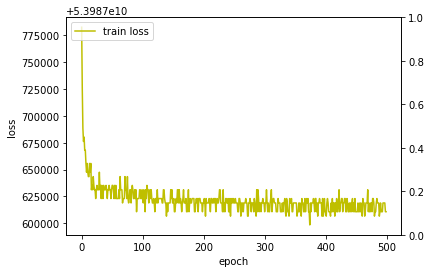

In [28]:
# Display acc, loss

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

# acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

plt.show()

In [40]:
### Test the model###

vae.evaluate(np.array(X_test).transpose([0,1,2,3]), np.array(X_test).transpose([0,1,2,3]), verbose=1)

3/3 [==============================] - 0s 49ms/step - loss: 3854244096.0000


3854244096.0

### Classification

In [61]:
def fc(enco, bi_class, num_classes):

#     den = Dense(17)(enco)
#     den = BatchNormalization()(den)
#     den = tf.keras.layers.LeakyReLU()(den)
    if bi_class == 0:
        den = Dense(num_classes, activation='softmax')(enco)
    else:
        den = Dense(2, activation='softmax')(enco)
#     den = BatchNormalization()(den)
#     den = tf.keras.layers.LeakyReLU()(den)
#     den = Dense(7)(den)
#     den = BatchNormalization()(den)
#     out = tf.keras.activations.softmax(den)
    
    return den

In [62]:
encode = encoder(feature_input)
full_model = Model(feature_input,fc(encode, bi_class, num_classes), name="Classification_model")
full_model.summary()

Model: "Classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 276, 50, 31)]     0         
_________________________________________________________________
encoder_model (Functional)   (None, 31)                1414731   
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 224       
Total params: 1,414,955
Trainable params: 224
Non-trainable params: 1,414,731
_________________________________________________________________


In [63]:
for layer in full_model.layers[0:2]:
    layer.trainable = False

In [64]:
if bi_class == 0:
    full_model.compile(optimizer=Adam(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.AUC(), tfa.metrics.F1Score(num_classes=num_classes)])
    hist = full_model.fit(x=np.array(X_train).transpose([0,1,2,3]), y=np.array(Y_train).transpose([0,1]), batch_size=None, validation_split=0.2, epochs=500)
else:
    full_model.compile(optimizer=Adam(lr=0.05), loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC()])
    hist = full_model.fit(x=np.array(X_train).transpose([0,1,2,3]), y=np.array(Y_train).transpose([0,1]), batch_size=None, validation_split=0.2, epochs=500)

Epoch 1/500
17/17 [==============================] - 3s 155ms/step - loss: 1.9153 - accuracy: 0.1974 - auc_3: 0.6201 - f1_score: 0.1453 - val_loss: 3.4387 - val_accuracy: 0.0000e+00 - val_auc_3: 0.1449 - val_f1_score: 0.0000e+00
Epoch 2/500
17/17 [==============================] - 1s 62ms/step - loss: 1.8720 - accuracy: 0.2049 - auc_3: 0.6441 - f1_score: 0.1703 - val_loss: 3.0767 - val_accuracy: 0.0075 - val_auc_3: 0.1930 - val_f1_score: 0.0034
Epoch 3/500
17/17 [==============================] - 1s 61ms/step - loss: 1.8482 - accuracy: 0.2387 - auc_3: 0.6560 - f1_score: 0.1886 - val_loss: 3.2067 - val_accuracy: 0.0226 - val_auc_3: 0.1954 - val_f1_score: 0.0101
Epoch 4/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8271 - accuracy: 0.2350 - auc_3: 0.6619 - f1_score: 0.1914 - val_loss: 2.8332 - val_accuracy: 0.0075 - val_auc_3: 0.2758 - val_f1_score: 0.0034
Epoch 5/500
17/17 [==============================] - 1s 61ms/step - loss: 1.8354 - accuracy: 0.2256 - auc_3: 0.

Epoch 38/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8008 - accuracy: 0.2838 - auc_3: 0.6755 - f1_score: 0.2415 - val_loss: 3.1528 - val_accuracy: 0.0000e+00 - val_auc_3: 0.1996 - val_f1_score: 0.0000e+00
Epoch 39/500
17/17 [==============================] - 1s 62ms/step - loss: 1.8116 - accuracy: 0.2707 - auc_3: 0.6709 - f1_score: 0.2028 - val_loss: 2.7086 - val_accuracy: 0.0075 - val_auc_3: 0.3154 - val_f1_score: 0.0034
Epoch 40/500
17/17 [==============================] - 1s 61ms/step - loss: 1.8337 - accuracy: 0.2519 - auc_3: 0.6568 - f1_score: 0.2010 - val_loss: 3.5874 - val_accuracy: 0.0226 - val_auc_3: 0.1695 - val_f1_score: 0.0153
Epoch 41/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8549 - accuracy: 0.2256 - auc_3: 0.6524 - f1_score: 0.1708 - val_loss: 3.3374 - val_accuracy: 0.0000e+00 - val_auc_3: 0.1580 - val_f1_score: 0.0000e+00
Epoch 42/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8047 - accuracy: 0.2500

Epoch 75/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7975 - accuracy: 0.2951 - auc_3: 0.6745 - f1_score: 0.2418 - val_loss: 2.8173 - val_accuracy: 0.0526 - val_auc_3: 0.3193 - val_f1_score: 0.0250
Epoch 76/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7959 - accuracy: 0.2876 - auc_3: 0.6760 - f1_score: 0.2222 - val_loss: 3.0013 - val_accuracy: 0.0451 - val_auc_3: 0.2303 - val_f1_score: 0.0195
Epoch 77/500
17/17 [==============================] - 1s 59ms/step - loss: 1.8083 - accuracy: 0.2556 - auc_3: 0.6687 - f1_score: 0.2147 - val_loss: 2.9546 - val_accuracy: 0.0301 - val_auc_3: 0.2397 - val_f1_score: 0.0133
Epoch 78/500
17/17 [==============================] - 1s 59ms/step - loss: 1.8234 - accuracy: 0.2613 - auc_3: 0.6764 - f1_score: 0.1877 - val_loss: 2.9026 - val_accuracy: 0.0301 - val_auc_3: 0.2752 - val_f1_score: 0.0133
Epoch 79/500
17/17 [==============================] - 1s 61ms/step - loss: 1.7972 - accuracy: 0.2519 - auc_3: 0.6718

Epoch 112/500
17/17 [==============================] - 1s 59ms/step - loss: 1.8178 - accuracy: 0.2425 - auc_3: 0.6639 - f1_score: 0.1810 - val_loss: 3.2634 - val_accuracy: 0.0226 - val_auc_3: 0.1852 - val_f1_score: 0.0148
Epoch 113/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8047 - accuracy: 0.2669 - auc_3: 0.6769 - f1_score: 0.2007 - val_loss: 2.9082 - val_accuracy: 0.0075 - val_auc_3: 0.2674 - val_f1_score: 0.0034
Epoch 114/500
17/17 [==============================] - 1s 59ms/step - loss: 1.7919 - accuracy: 0.2575 - auc_3: 0.6782 - f1_score: 0.1906 - val_loss: 2.6146 - val_accuracy: 0.0526 - val_auc_3: 0.3202 - val_f1_score: 0.0225
Epoch 115/500
17/17 [==============================] - 1s 64ms/step - loss: 1.8100 - accuracy: 0.2500 - auc_3: 0.6721 - f1_score: 0.1793 - val_loss: 2.9287 - val_accuracy: 0.0301 - val_auc_3: 0.2680 - val_f1_score: 0.0156
Epoch 116/500
17/17 [==============================] - 1s 59ms/step - loss: 1.8182 - accuracy: 0.2462 - auc_3: 0

Epoch 149/500
17/17 [==============================] - 1s 63ms/step - loss: 1.8290 - accuracy: 0.2481 - auc_3: 0.6714 - f1_score: 0.1909 - val_loss: 2.9796 - val_accuracy: 0.0075 - val_auc_3: 0.2804 - val_f1_score: 0.0034
Epoch 150/500
17/17 [==============================] - 1s 63ms/step - loss: 1.8139 - accuracy: 0.2462 - auc_3: 0.6717 - f1_score: 0.2216 - val_loss: 3.2357 - val_accuracy: 0.0075 - val_auc_3: 0.1816 - val_f1_score: 0.0034
Epoch 151/500
17/17 [==============================] - 1s 62ms/step - loss: 1.7746 - accuracy: 0.2594 - auc_3: 0.6842 - f1_score: 0.1995 - val_loss: 2.8947 - val_accuracy: 0.0451 - val_auc_3: 0.2574 - val_f1_score: 0.0264
Epoch 152/500
17/17 [==============================] - 1s 62ms/step - loss: 1.7808 - accuracy: 0.2556 - auc_3: 0.6815 - f1_score: 0.2163 - val_loss: 3.4705 - val_accuracy: 0.0000e+00 - val_auc_3: 0.1915 - val_f1_score: 0.0000e+00
Epoch 153/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8043 - accuracy: 0.2801 - 

Epoch 186/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8278 - accuracy: 0.2594 - auc_3: 0.6709 - f1_score: 0.1876 - val_loss: 3.0000 - val_accuracy: 0.0075 - val_auc_3: 0.2300 - val_f1_score: 0.0034
Epoch 187/500
17/17 [==============================] - 1s 62ms/step - loss: 1.8023 - accuracy: 0.2425 - auc_3: 0.6782 - f1_score: 0.1826 - val_loss: 2.7116 - val_accuracy: 0.0827 - val_auc_3: 0.3015 - val_f1_score: 0.0380
Epoch 188/500
17/17 [==============================] - 1s 63ms/step - loss: 1.8076 - accuracy: 0.2312 - auc_3: 0.6708 - f1_score: 0.1730 - val_loss: 2.6923 - val_accuracy: 0.1203 - val_auc_3: 0.3259 - val_f1_score: 0.0580
Epoch 189/500
17/17 [==============================] - 1s 61ms/step - loss: 1.8170 - accuracy: 0.2538 - auc_3: 0.6686 - f1_score: 0.2097 - val_loss: 3.1297 - val_accuracy: 0.0301 - val_auc_3: 0.2560 - val_f1_score: 0.0208
Epoch 190/500
17/17 [==============================] - 1s 59ms/step - loss: 1.8040 - accuracy: 0.2519 - auc_3: 0

Epoch 223/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8152 - accuracy: 0.2575 - auc_3: 0.6745 - f1_score: 0.2032 - val_loss: 3.1090 - val_accuracy: 0.0075 - val_auc_3: 0.2043 - val_f1_score: 0.0054
Epoch 224/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8185 - accuracy: 0.2406 - auc_3: 0.6593 - f1_score: 0.1857 - val_loss: 2.9201 - val_accuracy: 0.0376 - val_auc_3: 0.2891 - val_f1_score: 0.0209
Epoch 225/500
17/17 [==============================] - 1s 61ms/step - loss: 1.7998 - accuracy: 0.2538 - auc_3: 0.6781 - f1_score: 0.2003 - val_loss: 3.0503 - val_accuracy: 0.0075 - val_auc_3: 0.2237 - val_f1_score: 0.0034
Epoch 226/500
17/17 [==============================] - 1s 61ms/step - loss: 1.8135 - accuracy: 0.2124 - auc_3: 0.6622 - f1_score: 0.1666 - val_loss: 2.9251 - val_accuracy: 0.0075 - val_auc_3: 0.2829 - val_f1_score: 0.0055
Epoch 227/500
17/17 [==============================] - 1s 61ms/step - loss: 1.7659 - accuracy: 0.2857 - auc_3: 0

17/17 [==============================] - 1s 60ms/step - loss: 1.8119 - accuracy: 0.2519 - auc_3: 0.6698 - f1_score: 0.2097 - val_loss: 2.7292 - val_accuracy: 0.1203 - val_auc_3: 0.3237 - val_f1_score: 0.0544
Epoch 260/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7713 - accuracy: 0.2650 - auc_3: 0.6878 - f1_score: 0.2021 - val_loss: 2.9687 - val_accuracy: 0.0376 - val_auc_3: 0.2676 - val_f1_score: 0.0164
Epoch 261/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7761 - accuracy: 0.2594 - auc_3: 0.6937 - f1_score: 0.2131 - val_loss: 2.7143 - val_accuracy: 0.0827 - val_auc_3: 0.3188 - val_f1_score: 0.0361
Epoch 262/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8128 - accuracy: 0.2556 - auc_3: 0.6713 - f1_score: 0.1988 - val_loss: 2.6227 - val_accuracy: 0.0752 - val_auc_3: 0.3762 - val_f1_score: 0.0311
Epoch 263/500
17/17 [==============================] - 1s 61ms/step - loss: 1.7976 - accuracy: 0.2613 - auc_3: 0.6782 - f1_sco

Epoch 296/500
17/17 [==============================] - 1s 62ms/step - loss: 1.7830 - accuracy: 0.2613 - auc_3: 0.6853 - f1_score: 0.1979 - val_loss: 3.0742 - val_accuracy: 0.0301 - val_auc_3: 0.2498 - val_f1_score: 0.0193
Epoch 297/500
17/17 [==============================] - 1s 59ms/step - loss: 1.7967 - accuracy: 0.2744 - auc_3: 0.6780 - f1_score: 0.2140 - val_loss: 2.6113 - val_accuracy: 0.0752 - val_auc_3: 0.3778 - val_f1_score: 0.0395
Epoch 298/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7661 - accuracy: 0.2575 - auc_3: 0.6852 - f1_score: 0.2143 - val_loss: 2.7615 - val_accuracy: 0.0827 - val_auc_3: 0.3153 - val_f1_score: 0.0437
Epoch 299/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8079 - accuracy: 0.2575 - auc_3: 0.6696 - f1_score: 0.2303 - val_loss: 2.9199 - val_accuracy: 0.0301 - val_auc_3: 0.3021 - val_f1_score: 0.0174
Epoch 300/500
17/17 [==============================] - 1s 59ms/step - loss: 1.7859 - accuracy: 0.2594 - auc_3: 0

Epoch 333/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8056 - accuracy: 0.2669 - auc_3: 0.6755 - f1_score: 0.2038 - val_loss: 3.0648 - val_accuracy: 0.0075 - val_auc_3: 0.2516 - val_f1_score: 0.0034
Epoch 334/500
17/17 [==============================] - 1s 61ms/step - loss: 1.8072 - accuracy: 0.2274 - auc_3: 0.6694 - f1_score: 0.1771 - val_loss: 2.7397 - val_accuracy: 0.0526 - val_auc_3: 0.3307 - val_f1_score: 0.0250
Epoch 335/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7953 - accuracy: 0.2613 - auc_3: 0.6792 - f1_score: 0.1969 - val_loss: 3.2290 - val_accuracy: 0.0075 - val_auc_3: 0.2025 - val_f1_score: 0.0055
Epoch 336/500
17/17 [==============================] - 1s 61ms/step - loss: 1.8213 - accuracy: 0.2312 - auc_3: 0.6626 - f1_score: 0.1898 - val_loss: 3.9337 - val_accuracy: 0.0000e+00 - val_auc_3: 0.1775 - val_f1_score: 0.0000e+00
Epoch 337/500
17/17 [==============================] - 1s 63ms/step - loss: 1.8210 - accuracy: 0.2707 - 

Epoch 370/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7770 - accuracy: 0.2726 - auc_3: 0.6881 - f1_score: 0.2078 - val_loss: 3.2007 - val_accuracy: 0.0451 - val_auc_3: 0.2171 - val_f1_score: 0.0273
Epoch 371/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7926 - accuracy: 0.2613 - auc_3: 0.6795 - f1_score: 0.2167 - val_loss: 3.0303 - val_accuracy: 0.0075 - val_auc_3: 0.2430 - val_f1_score: 0.0034
Epoch 372/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8263 - accuracy: 0.2444 - auc_3: 0.6600 - f1_score: 0.1941 - val_loss: 3.2498 - val_accuracy: 0.0075 - val_auc_3: 0.2042 - val_f1_score: 0.0034
Epoch 373/500
17/17 [==============================] - 1s 59ms/step - loss: 1.8068 - accuracy: 0.2556 - auc_3: 0.6793 - f1_score: 0.2162 - val_loss: 3.7237 - val_accuracy: 0.0075 - val_auc_3: 0.1858 - val_f1_score: 0.0055
Epoch 374/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8476 - accuracy: 0.2387 - auc_3: 0

Epoch 407/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8285 - accuracy: 0.2500 - auc_3: 0.6591 - f1_score: 0.2053 - val_loss: 3.1331 - val_accuracy: 0.0075 - val_auc_3: 0.2200 - val_f1_score: 0.0034
Epoch 408/500
17/17 [==============================] - 1s 59ms/step - loss: 1.8013 - accuracy: 0.2876 - auc_3: 0.6794 - f1_score: 0.2373 - val_loss: 2.8161 - val_accuracy: 0.0677 - val_auc_3: 0.2925 - val_f1_score: 0.0368
Epoch 409/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8258 - accuracy: 0.2237 - auc_3: 0.6675 - f1_score: 0.1690 - val_loss: 3.0780 - val_accuracy: 0.0000e+00 - val_auc_3: 0.2271 - val_f1_score: 0.0000e+00
Epoch 410/500
17/17 [==============================] - 1s 61ms/step - loss: 1.7916 - accuracy: 0.2462 - auc_3: 0.6717 - f1_score: 0.1918 - val_loss: 2.6953 - val_accuracy: 0.0526 - val_auc_3: 0.3100 - val_f1_score: 0.0250
Epoch 411/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7877 - accuracy: 0.2744 - 

17/17 [==============================] - 1s 60ms/step - loss: 1.7968 - accuracy: 0.2726 - auc_3: 0.6789 - f1_score: 0.2056 - val_loss: 2.9732 - val_accuracy: 0.0075 - val_auc_3: 0.2657 - val_f1_score: 0.0054
Epoch 444/500
17/17 [==============================] - 1s 59ms/step - loss: 1.8067 - accuracy: 0.2462 - auc_3: 0.6692 - f1_score: 0.2139 - val_loss: 2.7538 - val_accuracy: 0.0602 - val_auc_3: 0.3037 - val_f1_score: 0.0333
Epoch 445/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7963 - accuracy: 0.2500 - auc_3: 0.6806 - f1_score: 0.2000 - val_loss: 2.8616 - val_accuracy: 0.0226 - val_auc_3: 0.2654 - val_f1_score: 0.0122
Epoch 446/500
17/17 [==============================] - 1s 59ms/step - loss: 1.8017 - accuracy: 0.2387 - auc_3: 0.6753 - f1_score: 0.1980 - val_loss: 3.1446 - val_accuracy: 0.0075 - val_auc_3: 0.2230 - val_f1_score: 0.0055
Epoch 447/500
17/17 [==============================] - 1s 59ms/step - loss: 1.8303 - accuracy: 0.2406 - auc_3: 0.6631 - f1_sco

17/17 [==============================] - 1s 61ms/step - loss: 1.7857 - accuracy: 0.2538 - auc_3: 0.6796 - f1_score: 0.1926 - val_loss: 3.0146 - val_accuracy: 0.0150 - val_auc_3: 0.2452 - val_f1_score: 0.0089
Epoch 480/500
17/17 [==============================] - 1s 61ms/step - loss: 1.7485 - accuracy: 0.2688 - auc_3: 0.6988 - f1_score: 0.2144 - val_loss: 2.7145 - val_accuracy: 0.0902 - val_auc_3: 0.3379 - val_f1_score: 0.0448
Epoch 481/500
17/17 [==============================] - 1s 61ms/step - loss: 1.7960 - accuracy: 0.2387 - auc_3: 0.6805 - f1_score: 0.1974 - val_loss: 2.7788 - val_accuracy: 0.0451 - val_auc_3: 0.2938 - val_f1_score: 0.0260
Epoch 482/500
17/17 [==============================] - 1s 60ms/step - loss: 1.7870 - accuracy: 0.2519 - auc_3: 0.6830 - f1_score: 0.1886 - val_loss: 2.8914 - val_accuracy: 0.0150 - val_auc_3: 0.3053 - val_f1_score: 0.0108
Epoch 483/500
17/17 [==============================] - 1s 60ms/step - loss: 1.8186 - accuracy: 0.2444 - auc_3: 0.6695 - f1_sco

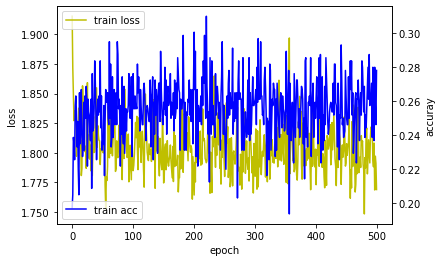

In [65]:
# Display acc, loss

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [66]:
predictions = full_model.predict(np.array(X_test).transpose([0,1,2,3]))

if bi_class==0:
    auc = roc_auc_score(Y_test, predictions, multi_class='raise')
    print('Multiclass Test AUC: ', auc)
else:
    auc = roc_auc_score(Y_test, predictions)
    print('Test AUC: ', auc)

Multiclass Test AUC:  0.5850009852327457


In [67]:
frequency = np.zeros(len(Y_test[0]))

for i in range(len(predictions)):
    frequency[np.argmax(predictions[i])] +=1

frequency

array([15., 19., 17.,  5., 13.,  3.,  1.])

In [68]:
print(np.sum(Y_test, axis=0))

[ 4.  7. 23. 23.  7.  6.  3.]


In [69]:
if bi_class == 0:
    test_loss, test_acc, test_auc, test_F1 = full_model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)
else:
    test_loss, test_acc, test_auc = full_model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
    print('\nAccuracy:', test_acc)

3/3 - 0s - loss: 2.0185 - accuracy: 0.1233 - auc_3: 0.5711 - f1_score: 0.0786

Accuracy: 0.12328767031431198


In [70]:
# ###Visualize Latent Space###

# x_test_encoded = encoder.predict(np.array(X_test).transpose([0,1,2,3]), batch_size=1)
# plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=Y_test)
# plt.colorbar()
# plt.show()
